<a href="https://colab.research.google.com/github/dolevi101/PPKMeans/blob/main/TiiKM_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [552]:
#!pip install numpy
#!pip install matplotlib
!pip install fuzzy-c-means

In [553]:
import copy
import time
import numpy as np
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import itertools
import random
from fcmeans import FCM

In [554]:
def fuzzy_c_means(n_clusters, data):
    my_model = FCM(n_clusters=n_clusters,m=3)
    my_model.fit(np.transpose(data)) ## X, numpy array. rows:samples columns:features
    labels_data = [0]*data.shape[1]
    labels_centers = [1]*(my_model.centers.shape[0])
    labels = labels_data + labels_centers
    X = np.concatenate((data,my_model.centers),axis=None)
    print_fig(X, labels, "real fuzzy_c_means")
    return my_model.centers


def real_kmeans(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(np.array(data))

    labels_data = [0]*len(data)
    labels_centers = list(range(1, len(kmeans.cluster_centers_) + 1))
    X = data + list(kmeans.cluster_centers_)
    x_data = [row[0] for row in X]
    y_data = [row[1] for row in X]
    colors = labels_data + labels_centers
    print_fig(x_data, y_data, "Real kMeans", iteration=0, colors=colors, tochange=True)

    return kmeans.cluster_centers_

In [631]:
def print_fig(X, Y, plot_name, iteration=0, colors=None, tochange=None):
    # Create a scatter plot
    fig, axs = plt.subplots(nrows=1, ncols=1)
    #centers_colors = [(item+1) for item in centers_colors]
    if colors is None:
      axs.scatter(x=X, y=Y, c=Y)
    else:
      axs.scatter(x=X, y=Y, c=colors)
    if iteration==0:
      axs.set_title(plot_name)
    else:
      axs.set_title(plot_name + ": iteration={}".format(iteration))
    if tochange is None:
      axs.set_ylim(-1, 6)
      axs.set_xlim(0, 1)
      fig.set_figheight(1.5)
    else:
      axs.set_ylim(0, 1)
      axs.set_xlim(0, 1)
    fig.show()

In [556]:
def distance_2d(a, b):
  return math.dist(a, b)


def power(base, exponent):
    result = 1
    if exponent < 0:
        base = 1 / base
        exponent = -exponent
    while exponent > 0:
        if exponent % 2 == 1:
            result *= base
        base *= base
        exponent //= 2
    return result


def get_p_value(dis_p, sum_distance_p, p,n):
  approx = inverse(sum_distance_p, n)
  #dis_p = dis ** p
  #dis_p = power(dis, p)
  prob = dis_p * approx
  return prob


def inverse(x, n):
    return 1/x
    a = 2 - x
    b = 1 - x
    for i in range(n):
        b = b**2
        a = a*(1 + b)
    return a

In [557]:
def prob_to_be_in_center_2d(data, centers, p,n):
  num_of_centers = len(centers)
  num_of_points = len(data)
  #distances = []
  distances_p = []
  sum_distance_p_from_centers = []
  for c in centers:
      dises = []
      for x in data:
            dis = distance_2d(x, c)
            dises.append(dis)
            #dises.append(dis**p)
            #dises.append(power(dis, p))

      all_dis_per_center = [(max(dises) - item + 0.05) for item in dises]

      all_dis_p_per_center = []
      sum_distance_p_from_single_center = 0
      for item in all_dis_per_center:
        powered_item = power(item, p)
        all_dis_p_per_center.append(powered_item)
        sum_distance_p_from_single_center += powered_item

      #distances.append(all_dis_per_center)
      distances_p.append(all_dis_p_per_center)
      sum_distance_p_from_centers.append(sum_distance_p_from_single_center)


  probs = []
  p_values_sum = []

  for i in range(num_of_centers):
    probs_sum = [0, 0]
    p_values_sum_per_center = 0
    for j in range(num_of_points):
        p_value = get_p_value(distances_p[i][j], sum_distance_p_from_centers[i], p, n)
        #print("p_value: ", p_value)
        temp_point_contrib = [item * p_value for item in data[j]]
        probs_sum = [x + y for x, y in zip(probs_sum, temp_point_contrib)]
        p_values_sum_per_center += p_value
    probs.append(probs_sum)
    p_values_sum.append(p_values_sum_per_center)

  return probs, p_values_sum

In [619]:
def run_one_mean_2d(data, n, p, iterations, to_print, to_draw, to_draw_milestones):
    #generate random center
    centers = [[random.uniform(0, 1), random.uniform(0, 1)]]

    #plot the start position
    if to_draw_milestones:
      labels_data = [0]*len(data)
      labels_centers = list(range(1, len(centers) + 1))
      X = data + centers
      x_data = [row[0] for row in X]
      y_data = [row[1] for row in X]
      colors = labels_data + labels_centers
      print_fig(x_data, y_data, "our kmeans 2d: Start Position", iteration=0, colors=colors, tochange=True)

    #first iteration
    start = time.time()
    probs, p_values_sum = prob_to_be_in_center_2d(data, centers, p, n)
    new_centers = [[(item/p_values_sum[c_index]) for item in probs[c_index]] for c_index in range(len(centers))]
    end = time.time()

    if to_print:
      print("({}/{}) centers = {}, Duration: {} seconds".format(1, iterations, new_centers, end - start))
    for i in range(1, iterations):
        start = time.time()
        probs, p_values_sum = prob_to_be_in_center_2d(data, new_centers,p,n)
        new_centers = [[(item/p_values_sum[c_index]) for item in probs[c_index]] for c_index in range(len(centers))]

        end = time.time()
        if to_print:
          print("({}/{}) centers = {}, Duration: {} seconds".format(i+1, iterations, new_centers, end - start))
        if to_draw:
          labels_data = [0]*len(data)
          labels_centers = list(range(1, len(new_centers) + 1))
          X = data + new_centers
          x_data = [row[0] for row in X]
          y_data = [row[1] for row in X]
          colors = labels_data + labels_centers
          print_fig(x_data, y_data, "our kmeans 2d", iteration=i, colors=colors, tochange=True)

    #plot the final position
    if to_draw_milestones:
      labels_data = [0]*len(data)
      labels_centers = list(range(1, len(new_centers) + 1))
      X = data + new_centers
      x_data = [row[0] for row in X]
      y_data = [row[1] for row in X]
      colors = labels_data + labels_centers
      print_fig(x_data, y_data, "our kmeans 2d: Final Position", iteration=0, colors=colors, tochange=True)

    return new_centers[0]

In [559]:
def is_new_center_2d(temp_center, known_centers, known_intervals):
  for center_index in range(len(known_centers)):
    checked_center_location = known_centers[center_index]
    checked_center_interval = known_intervals[center_index]

    temp_center_x = temp_center[0]
    temp_center_y = temp_center[1]

    checked_center_x = checked_center_location[0]
    checked_center_y = checked_center_location[1]

    temp_calc = (temp_center_x - checked_center_x) ** 2 + (temp_center_y - checked_center_y) ** 2
    #(x - center_x)² + (y - center_y)² < radius²

    if temp_calc <= checked_center_interval ** 2:
      return (False, checked_center_location, checked_center_interval)
  return (True, -1, -1)

In [628]:
def new_kmeans_2d(data, k, n, p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones = False):
  final_centers = []
  final_intervals = []
  original_data = data.copy()

  #calculating center number i from total k
  for current_center_index in range(k):
    current_interval = interval

    for i in range(iterations_for_center):
      if len(data) == 0:
        break
      temp_center = run_one_mean_2d(data, n, p, internal_iterations, to_print, to_draw, to_draw_milestones)

      check_if_new_center = is_new_center_2d(temp_center, final_centers, final_intervals)
      is_search_stopped = check_if_new_center[0]
      prev_center = check_if_new_center[1]
      prev_interval = check_if_new_center[2]
      if is_search_stopped:
        # the new center is far from the previous centers
        # meaning we have found a new center, save it
        # move to the next one
        final_centers.append(temp_center)
        final_intervals.append(current_interval)
        data = remove_data_around_center(data, temp_center, current_interval)

        if to_draw_milestones:
          labels_data = [0]*len(original_data)
          labels_centers = list(range(1, len(final_centers) + 1))
          X = original_data + final_centers
          x_data = [row[0] for row in X]
          y_data = [row[1] for row in X]
          colors = labels_data + labels_centers
          print_fig(x_data, y_data, "our kmeans 2d: Current Centers: {}".format(final_centers), iteration=0, colors=colors, tochange=True)

        break

      # we got to an existing cluster which already has a center
      # so we would like to start searching again
      # remove data around previous center and double the previous interval

      data = remove_data_around_center(data, prev_center, 2 * prev_interval)
      #todo, update the known interval for previous center

  labels_data = [0]*len(original_data)
  labels_centers = list(range(1, len(final_centers) + 1))
  X = original_data + final_centers
  x_data = [row[0] for row in X]
  y_data = [row[1] for row in X]
  colors = labels_data + labels_centers
  print_fig(x_data, y_data, "our kmeans 2d: TADAM", iteration=0, colors=colors, tochange=True)

  return final_centers

In [561]:
def remove_data_around_center(data, center, interval):
  updated_data = []

  for point in data:
    point_x = point[0]
    point_y = point[1]

    center_x = center[0]
    center_y = center[1]

    #(x - center_x)² + (y - center_y)² < radius²
    temp_calc = (point_x - center_x) ** 2 + (point_y - center_y) ** 2

    if temp_calc > interval ** 2:
      updated_data.append(point)

  return updated_data

In [ ]:
data = []
data.extend([[x/100,0.13] for x in list(range(10,18))])
data.extend([[x/100,0.18] for x in list(range(10,18))])
data.extend([[x/100,0.23] for x in list(range(10,18))])

data.extend([[x/100,0.3] for x in list(range(30,40))])
data.extend([[x/100,0.35] for x in list(range(30,40))])
data.extend([[x/100,0.4] for x in list(range(30,40))])

data.extend([[x/100,0.7] for x in list(range(70,80))])
data.extend([[x/100,0.75] for x in list(range(70,80))])
data.extend([[x/100,0.8] for x in list(range(70,80))])

#data.extend([x/100 for x in list(range(90,95))])
original_data = data.copy()

#print_fig([row[0] for row in data], [row[1] for row in data], "plot_name", tochange=True)

#variables
k = 3
n = 3
p = 5
iterations_for_center = 10
internal_iterations = 20
interval = 0.05
to_print = False
to_draw = False
to_draw_milestones = True

discovered_centers = new_kmeans_2d(data, k, n, p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones)
#suggestion, run the same algorithm, but now data=discovered_centers

#fuzzy_c_means(k, (np.asarray(data)).reshape(1,-1))
#real_kmeans(k, data)

#TODO: intersection overlapping interval
#todo, update the known interval for previous center in new_kmeans_2d to be doubled

In [586]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Load the MNIST dataset
mnist = fetch_openml(name='mnist_784', version=1)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


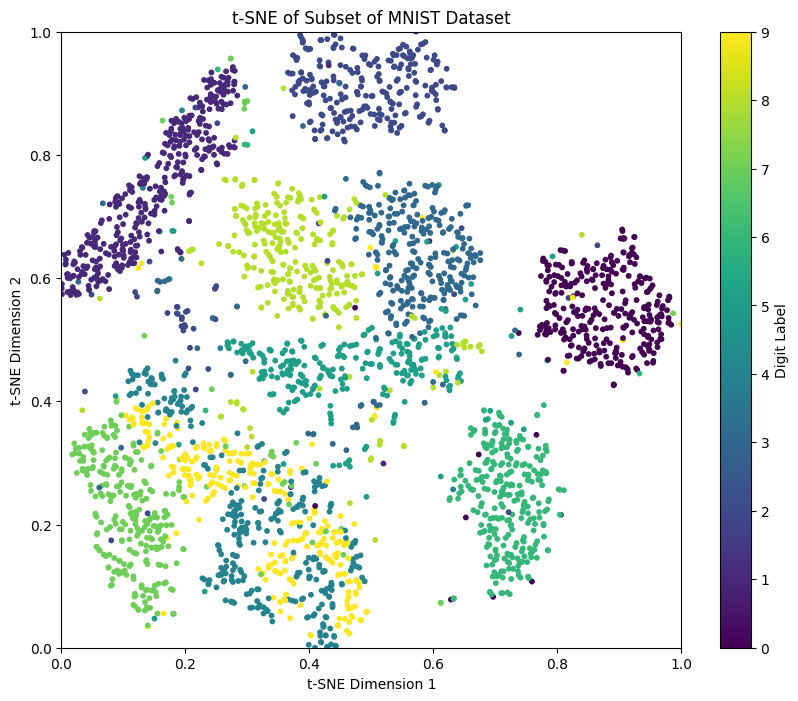

In [644]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

X = mnist.data
y = mnist.target

# Define the number of samples to retain
num_samples = 3000

# Randomly select a subset of data and labels
random_indices = np.random.choice(X.shape[0], num_samples, replace=False)
X_subset = X.iloc[random_indices]
y_subset = y.iloc[random_indices]
c = [int(item) for item in y_subset]


# Perform t-SNE for dimensionality reduction to 2 components
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_subset)

# Normalize the data to the interval [0, 1]
scaler = MinMaxScaler()
X_tsne = scaler.fit_transform(X_tsne)

# Create a scatter plot to visualize the t-SNE-reduced subset
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=c, cmap='viridis', s=10)
plt.colorbar(label='Digit Label')
plt.title('t-SNE of Subset of MNIST Dataset')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

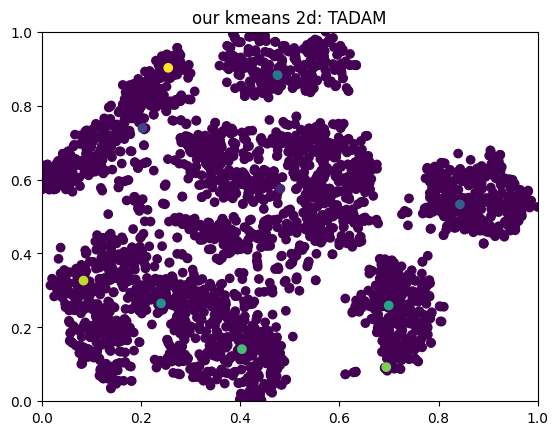

In [646]:
#our kMeans-2d
data = X_tsne
data = list(list(item) for item in data)
k = 10
n = 3
p = 10
iterations_for_center = 10
internal_iterations = 20
interval = 0.15
to_print = False
to_draw = False
to_draw_milestones = False
discovered_centers = new_kmeans_2d(data, k, n, p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


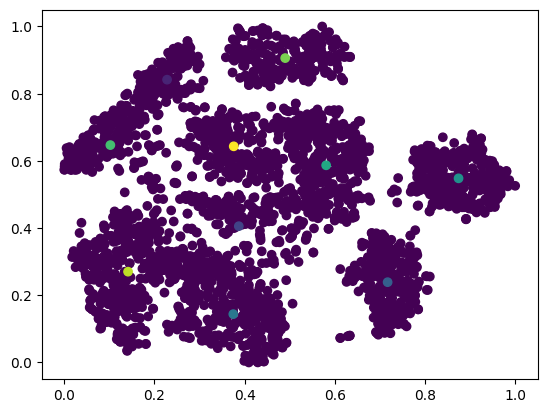

In [645]:
#Real kMeans
n_clusters = 10
data = X_tsne
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(np.array(data))

labels_data = [0]*len(data)
labels_centers = list(range(1, len(kmeans.cluster_centers_) + 1))
X = list(data) + list(kmeans.cluster_centers_)
x_data = [row[0] for row in X]
y_data = [row[1] for row in X]
colors = labels_data + labels_centers
# Create a scatter plot
fig, axs = plt.subplots(nrows=1, ncols=1)
#centers_colors = [(item+1) for item in centers_colors]
axs.scatter(x=x_data, y=y_data, c=colors)
fig.show()